# Import Required Libraries
Import the necessary libraries, including NumPy, pandas, and scikit-learn.

In [1]:
# Required Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.signal import convolve

### Generate synthetic classification dataset

Time series dataset for a univariate classification problem with distinct 
classes represented by different distribution processes

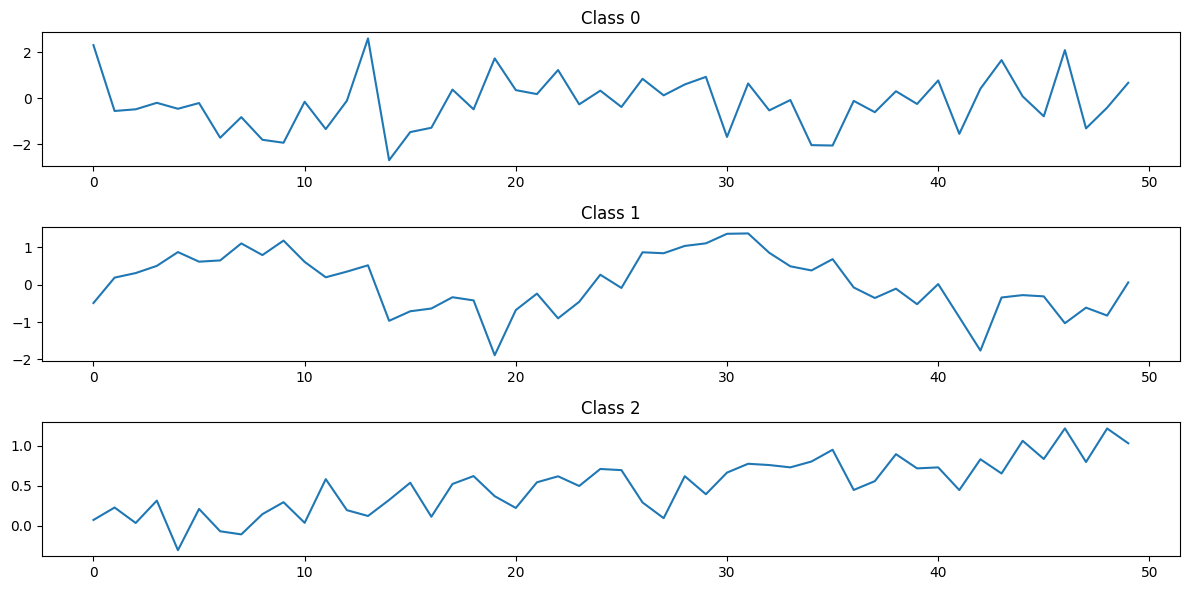

In [2]:
n_samples_per_class = 40
timesteps = 50

# Class 1: Normal distribution
class_1 = np.random.normal(loc=0, scale=1, size=(n_samples_per_class, timesteps))

# Class 2: Sinusoidal pattern with noise
time = np.linspace(0, 4*np.pi, timesteps)
class_2 = np.array([np.sin(time) + np.random.normal(scale=0.5, size=timesteps) for _ in range(n_samples_per_class)])

# Class 3: Linear trend with noise
class_3 = np.array([np.linspace(i, i + 1, timesteps) + np.random.normal(scale=0.2, size=timesteps) for i in range(n_samples_per_class)])

# Combine classes and labels
data = np.concatenate([class_1, class_2, class_3], axis=0)
labels = np.concatenate([np.zeros(n_samples_per_class), np.ones(n_samples_per_class), np.full(n_samples_per_class, 2)], axis=0)

# Visualization
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(data[labels.flatten() == i][0])
    plt.title(f'Class {i}')
plt.tight_layout()
plt.show()

# Generate Random 1-D Convolutional Kernels
Generate random 1-D convolutional kernels for the ROCKET algorithm.

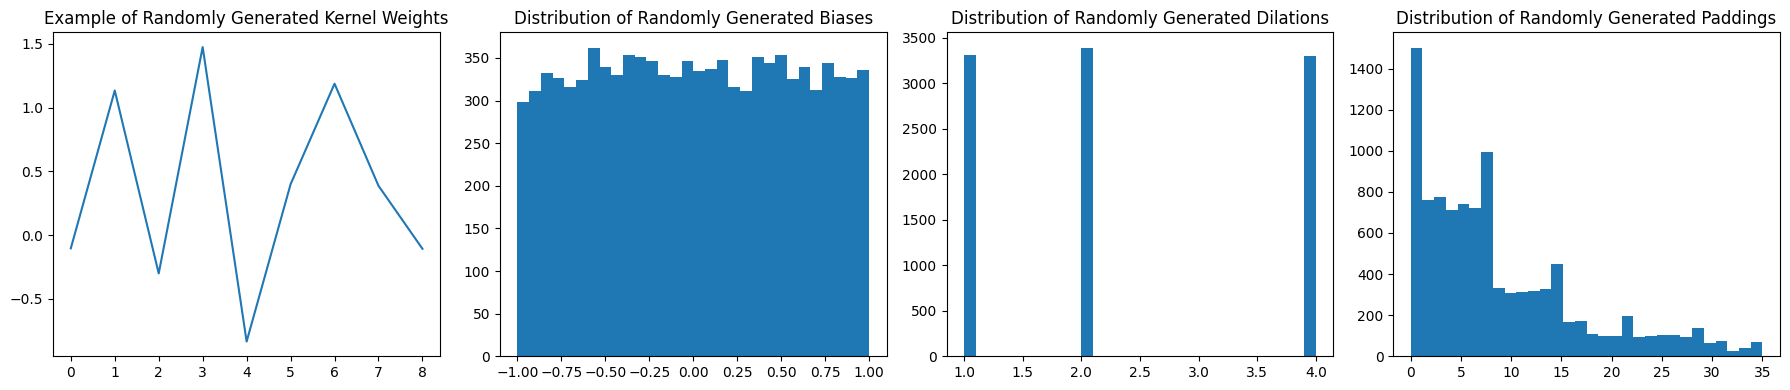

Weights length: 10000
Biases shape: (10000,)
Dilations shape: (10000,)
Paddings shape: 10000


In [3]:
# Define the number of kernels
num_kernels = 10000

# kernel length
kernel_lengths = np.random.randint(7, 10, num_kernels)

# Generate random weights for the kernels
weights = [np.random.normal(0, 1, kernel_length) for kernel_length in kernel_lengths]

# Generate random biases for the kernels
biases = np.random.uniform(-1, 1, num_kernels)

# Generate random dilation factors for the kernels
max_dilation = timesteps // kernel_lengths.min()
max_exponent = np.floor(np.log2(max_dilation)).astype(int)
dilations = np.random.choice([2**i for i in range(0, max_exponent + 1)], num_kernels)

# Generate random padding sizes for the kernels
paddings = np.array([np.random.choice(kernel_length * dilation) for \
            kernel_length, dilation in zip(kernel_lengths, dilations)])

# Visualize
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

# Plot kernel weights
axs[0].plot(weights[0])  # change this value to display a different kernel
axs[0].set_title('Example of Randomly Generated Kernel Weights')
# Plot biases
axs[1].hist(biases, bins=30)
axs[1].set_title('Distribution of Randomly Generated Biases')
# Plot dilations
axs[2].hist(dilations, bins=30)
axs[2].set_title('Distribution of Randomly Generated Dilations')
# Plot paddings
axs[3].hist(paddings, bins=30)
axs[3].set_title('Distribution of Randomly Generated Paddings')

plt.tight_layout()
plt.show()

# Print shapes
print(f'Weights length: {len(weights)}')
print(f'Biases shape: {biases.shape}')
print(f'Dilations shape: {dilations.shape}')
print(f'Paddings shape: {len(paddings)}')


# Create Activation Maps
Create activation (or feature) maps using the generated random 1-D convolutional kernels.

In [4]:
# Function to create 1-D convolutional kernels
def create_kernels(weights, biases, dilations, paddings):
    kernels = []
    for i in range(len(weights)):
        kernel = np.pad(weights[i] * dilations[i], paddings[i], mode='constant')
        kernel = kernel + biases[i]
        kernels.append(kernel)
    return kernels

# Create 1-D convolutional kernels
kernels = create_kernels(weights, biases, dilations, paddings)

# Function to create activation maps
def create_activation_maps(data, kernels):
    activation_maps = []
    for x in data:
        x_activation_maps = []
        for kernel in kernels:
            activation_map = convolve(x, kernel, mode='valid') # Considers only valid overlapping
            x_activation_maps.append(activation_map)
        activation_maps.append(x_activation_maps)
    return activation_maps

# Create activation maps
activation_maps = create_activation_maps(data, kernels)

print(f'Number of activation maps: {len(activation_maps)} x {num_kernels}')
print(f'Shape of first activation map: {activation_maps[0][0].shape}')

Number of activation maps: 30 x 10000
Shape of first activation map: (32,)


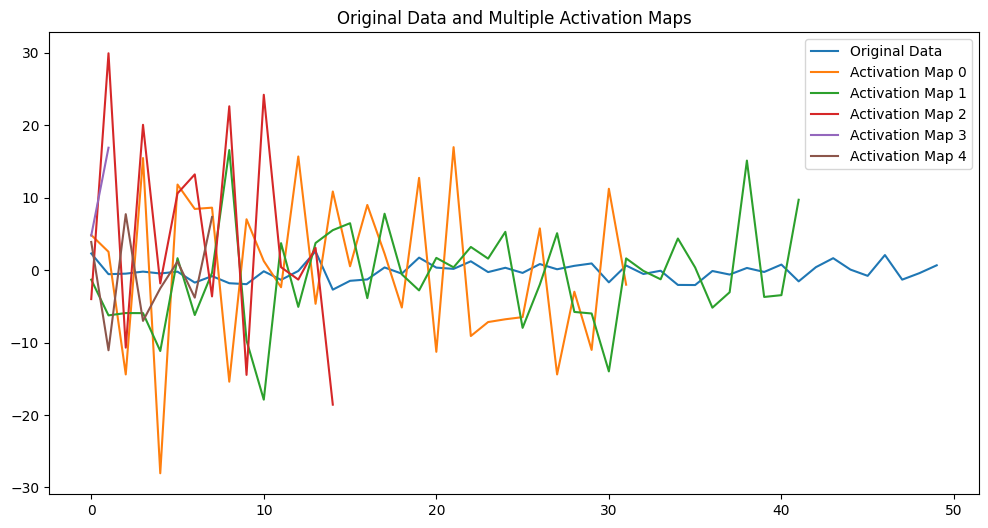

In [5]:
# Plot multiple activation maps of the same sample, along with the original sample
sample_index = 0
plt.figure(figsize=(12, 6))
plt.plot(data[sample_index], label='Original Data')
for i in range(5):
    plt.plot(activation_maps[sample_index][i], label=f'Activation Map {i}')
plt.legend()
plt.title('Original Data and Multiple Activation Maps')
plt.show()





# Compute Maximum Value (Max Pooling)
Compute the maximum value (max pooling) from the activation maps.

In [6]:
# Function to compute maximum value (max pooling) for every activation map of 
# every sample in the dataset, and return as a feature matrix
def compute_max_pooling(activation_maps):
    max_pooling = []
    for sample in activation_maps:
        for activation_map in sample:
            max_pooling.append(np.max(activation_map))
    return np.array(max_pooling).reshape(len(activation_maps), -1)

# Compute max pooling
X_max = compute_max_pooling(activation_maps)
print(f'Shape of feature matrix: {X_max.shape}')

Shape of feature matrix: (30, 10000)


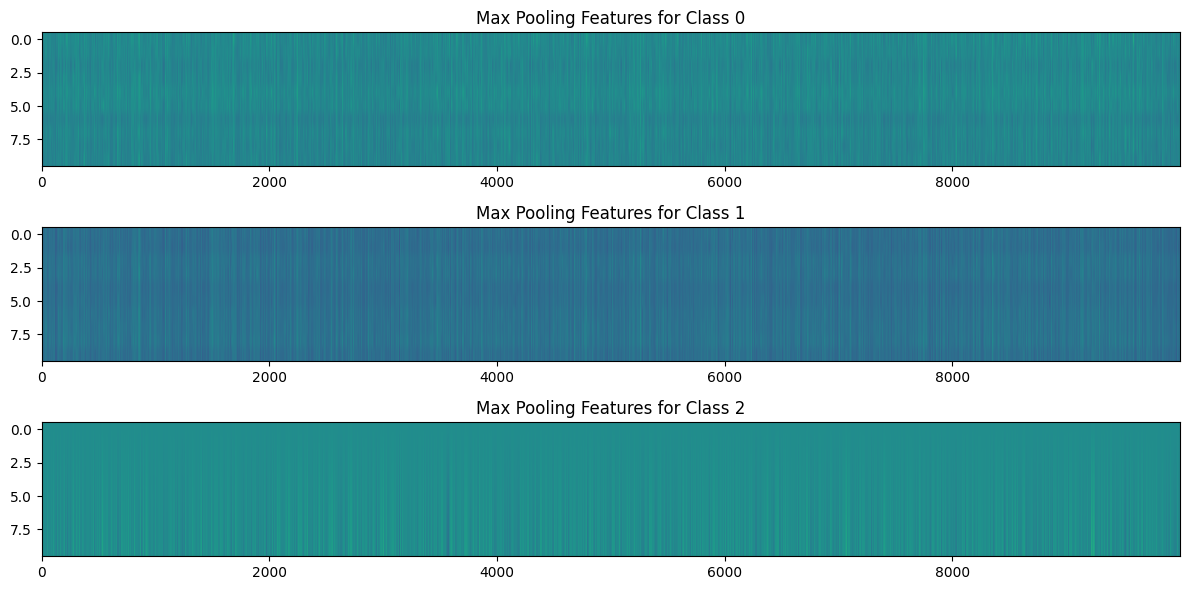

In [8]:
# plot the feature matrices (as a heatmap) for the three classes of the dataset
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.imshow(X_max[labels == i], aspect='auto')
    plt.title(f'Max Pooling Features for Class {i}')
plt.tight_layout()
plt.show()


# Compute Proportion of Positive Values (PPV)
Compute the proportion of positive values (PPV) from the activation maps.

In [9]:
# Function to compute proportion of positive values (PPV) for every activation 
# map of every sample in the dataset, and return as a feature matrix
def compute_ppv(activation_maps):
    ppv = []
    for sample in activation_maps:
        for activation_map in sample:
            ppv.append(np.sum(activation_map > 0) / len(activation_map))
    return np.array(ppv).reshape(len(activation_maps), -1)

# Compute PPV
X_ppv = compute_ppv(activation_maps)
print(f'Shape of feature matrix: {X_ppv.shape}')

Shape of feature matrix: (30, 10000)


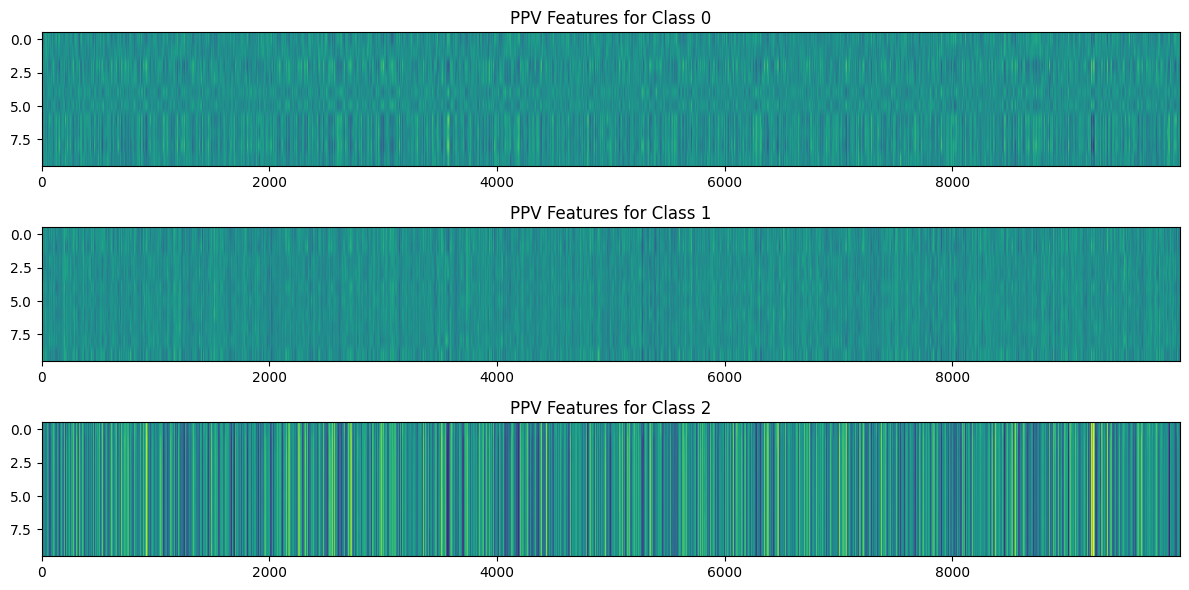

In [10]:
# plot the feature matrices (as a heatmap) for the three classes of the dataset
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.imshow(X_ppv[labels == i], aspect='auto')
    plt.title(f'PPV Features for Class {i}')
plt.tight_layout()
plt.show()

# Concatenate Max and PPV
Concatenate the max and PPV for all the random 1D kernels generated to form the final feature vector.

In [11]:
# Concatenate the max and PPV for all the random 1D kernels generated
X = np.concatenate([X_max, X_ppv], axis=1)
print(f'Shape of feature matrix: {X.shape}')

Shape of feature matrix: (30, 20000)


# Train a Linear Classifier
Train a linear classifier (e.g., Ridge regression or logistic regression) on the final feature vector.

In [12]:
# Define the classifier
classifier = RidgeClassifier()

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, 
                                                    random_state=0)

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 1.00


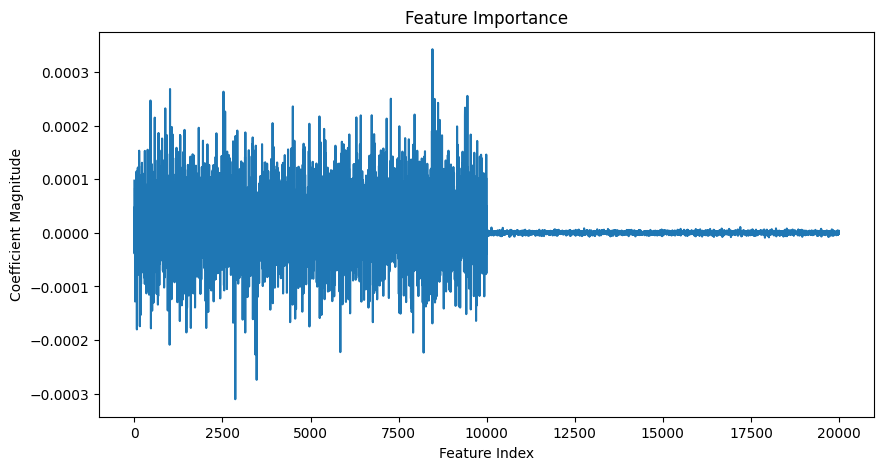

In [13]:
# Get the coefficients
coefficients = classifier.coef_

# Plot the coefficients
plt.figure(figsize=(10, 5))
plt.plot(coefficients[0])
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Magnitude')
plt.show()